In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('../data/widget_sales.csv')

df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


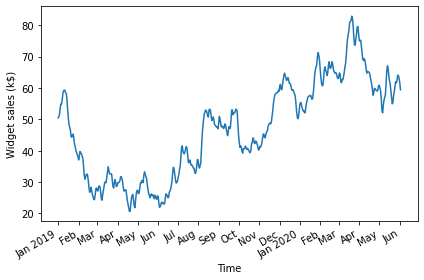

In [3]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH04_F01_peixeiro.png', dpi=300)

In [4]:
ADF_result = adfuller(df['widget_sales'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.5121662069359012
p-value: 0.5274845352272624


In [5]:
widget_sales_diff = np.diff(df['widget_sales'], n=1)

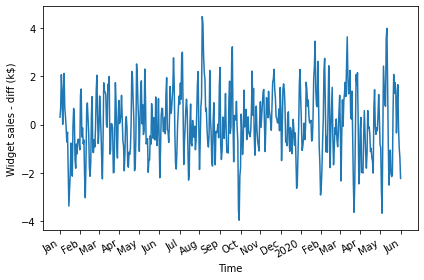

In [6]:
fig, ax = plt.subplots()

ax.plot(widget_sales_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH04_F05_peixeiro.png', dpi=300)

In [7]:
ADF_result = adfuller(widget_sales_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -10.576657780341957
p-value: 7.076922818587346e-19


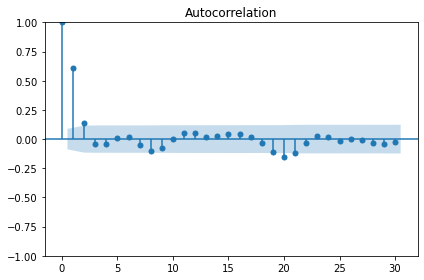

In [8]:
plot_acf(widget_sales_diff, lags=30);

plt.tight_layout()

plt.savefig('figures/CH04_F06_peixeiro.png', dpi=300)

In [9]:
df_diff = pd.DataFrame({'widget_sales_diff': widget_sales_diff})

train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]

print(len(train))
print(len(test))

449
50


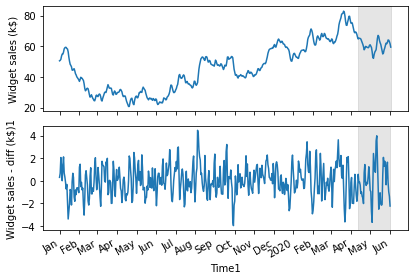

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['widget_sales'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k$)')
ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(df_diff['widget_sales_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget sales - diff (k$)1')
ax2.axvspan(449, 498, color='#808080', alpha=0.2)

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH04_F07_peixeiro.png', dpi=300)

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [16]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994


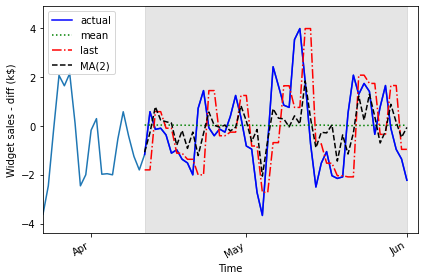

In [17]:
fig, ax = plt.subplots()

ax.plot(df_diff['widget_sales_diff'])
ax.plot(pred_df['widget_sales_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

ax.axvspan(449, 498, color='#808080', alpha=0.2)

ax.set_xlim(430, 500)

plt.xticks(
    [439, 468, 498], 
    ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH04_F08_peixeiro.png', dpi=300)

In [18]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

2.5606299456880537 3.2494260812249225 1.9481714497703646


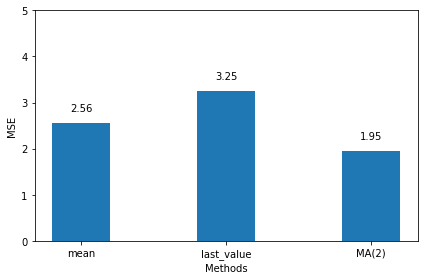

In [19]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH04_F09_peixeiro.png', dpi=300)

In [24]:
df['pred_widget_sales'] = pd.Series()
df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()

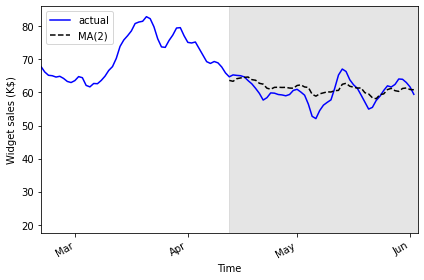

In [25]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'], 'b-', label='actual')
ax.plot(df['pred_widget_sales'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (K$)')

ax.axvspan(450, 500, color='#808080', alpha=0.2)

ax.set_xlim(400, 500)

plt.xticks(
    [409, 439, 468, 498], 
    ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH04_F11_peixeiro.png', dpi=300)

In [26]:
from sklearn.metrics import mean_absolute_error

mae_MA_undiff = mean_absolute_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])

print(mae_MA_undiff)

2.324470924412907
